# Models Evaluation

1. Create models
2. Compare models
3. Export .csv file with results

In [1]:
import pandas as pd
from datetime import date

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn import metrics

In [2]:
train_data = pd.read_pickle("train_data.pkl")
test_data = pd.read_pickle("test_data.pkl")

## Train Test Split

In [3]:
features = list(train_data.columns)
features.remove('status')
features.remove('loan_id')

x = train_data[features]
y = train_data['status']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

## Resampling

Our data analysis stage showed that our working dataset was heavily umbalanced.

Early exploratory analysis of classification methods proved that this was having a negative effect on the accuracy of the classifier, especially for the minority classes. To solve this problem we implemented resampling techniques that would generate a more balanced training set.

For oversampling we used the SMOTE (Synthetic Minority Over-sampling Technique) algorithm. This generates new samples interpolated from the existing ones.

In [4]:
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

Some of the algorithms we plan on using (KNN and SVM) require the data to be standardized. To do so, we used a StandardScaler from SciKit Learn's preprocessing library.

In [5]:
scaler = StandardScaler()

scaler.fit(x_train)
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

## Models

In [6]:
def apply_model(model, algorithm):
    model.fit(x_train, y_train)

    #Predict the response for test dataset
    model_pred = model.predict(x_test)
    model_pred_proba = model.predict_proba(x_test)[:, -1]

    # Metrics
    print(f"\nAUC Score: {metrics.roc_auc_score(y_test, model_pred_proba)}") # Area Under the Curve
    print(f"Confusion matrix:\n{metrics.confusion_matrix(y_test, model_pred)}\n")
    print(f"Classification report:\n{metrics.classification_report(y_test, model_pred)}\n")

    metrics.plot_roc_curve(model, x_test, y_test)
    #plt.savefig(f"{algorithm}.png")
    plt.show
    
    return model

## Decision Tree Classifier


AUC Score: 0.6747899159663865
Confusion matrix:
[[10  4]
 [34 51]]

Classification report:
              precision    recall  f1-score   support

          -1       0.23      0.71      0.34        14
           1       0.93      0.60      0.73        85

    accuracy                           0.62        99
   macro avg       0.58      0.66      0.54        99
weighted avg       0.83      0.62      0.67        99




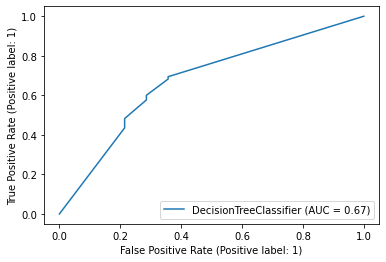

In [7]:
dtc = apply_model(DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=10, random_state=0), "dt")

## Random Forest


AUC Score: 0.7512605042016806
Confusion matrix:
[[ 8  6]
 [26 59]]

Classification report:
              precision    recall  f1-score   support

          -1       0.24      0.57      0.33        14
           1       0.91      0.69      0.79        85

    accuracy                           0.68        99
   macro avg       0.57      0.63      0.56        99
weighted avg       0.81      0.68      0.72        99




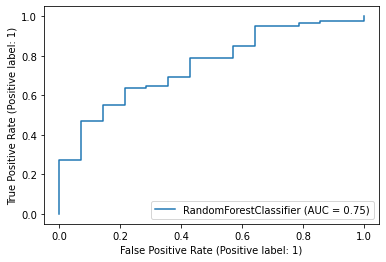

In [8]:
rf = apply_model(RandomForestClassifier(n_estimators=1500, random_state=0), "rf")

## KNN


AUC Score: 0.7747899159663866
Confusion matrix:
[[14  0]
 [44 41]]

Classification report:
              precision    recall  f1-score   support

          -1       0.24      1.00      0.39        14
           1       1.00      0.48      0.65        85

    accuracy                           0.56        99
   macro avg       0.62      0.74      0.52        99
weighted avg       0.89      0.56      0.61        99




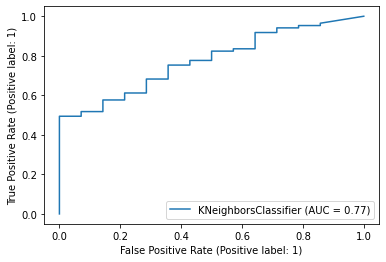

In [9]:
knn = apply_model(KNeighborsClassifier(algorithm='ball_tree', n_neighbors=10, weights='distance'), "knn")

## SVM


AUC Score: 0.8352941176470587
Confusion matrix:
[[ 9  5]
 [15 70]]

Classification report:
              precision    recall  f1-score   support

          -1       0.38      0.64      0.47        14
           1       0.93      0.82      0.87        85

    accuracy                           0.80        99
   macro avg       0.65      0.73      0.67        99
weighted avg       0.85      0.80      0.82        99




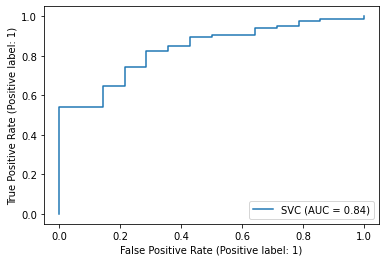

In [10]:
svm = apply_model(SVC(C=10, gamma='auto', probability=True, random_state=0), "svm")

## AdaBoost


AUC Score: 0.7142857142857143
Confusion matrix:
[[11  3]
 [42 43]]

Classification report:
              precision    recall  f1-score   support

          -1       0.21      0.79      0.33        14
           1       0.93      0.51      0.66        85

    accuracy                           0.55        99
   macro avg       0.57      0.65      0.49        99
weighted avg       0.83      0.55      0.61        99




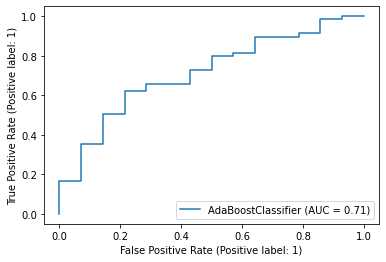

In [11]:
ada = apply_model(AdaBoostClassifier(n_estimators=100, random_state=0), "ada")

## GradientBoost


AUC Score: 0.7294117647058823
Confusion matrix:
[[11  3]
 [36 49]]

Classification report:
              precision    recall  f1-score   support

          -1       0.23      0.79      0.36        14
           1       0.94      0.58      0.72        85

    accuracy                           0.61        99
   macro avg       0.59      0.68      0.54        99
weighted avg       0.84      0.61      0.67        99




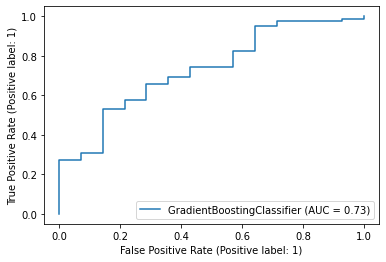

In [12]:
gb = apply_model(GradientBoostingClassifier(learning_rate=0.5, max_features='auto', min_samples_leaf=4, min_samples_split=10, n_estimators=150, random_state=0), "gb")

## XGBoost


AUC Score: 0.7672268907563025


C:\Users\fmna\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Confusion matrix:
[[12  2]
 [42 43]]

Classification report:
              precision    recall  f1-score   support

          -1       0.22      0.86      0.35        14
           1       0.96      0.51      0.66        85

    accuracy                           0.56        99
   macro avg       0.59      0.68      0.51        99
weighted avg       0.85      0.56      0.62        99




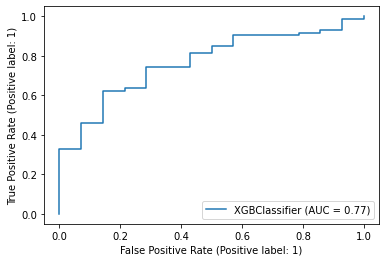

In [13]:
xbg = apply_model(XGBClassifier(objective='binary:logistic', use_label_encoder=True, eval_metric='auc'), "xgb")

## Submission

In [ ]:
x_real = test_data[features]

predictions = ada.predict_proba(x_real)[:, -1]

In [ ]:
submission = pd.DataFrame()
submission['Id'] = test_data['loan_id']
submission['Predicted'] = predictions

submission.to_csv(date.today().strftime("%d-%m-%Y") + '.csv', index=False)

In [ ]:
submission